In [1]:
import os
import sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

/Users/andrejizvarin/Documents/___project/emotion_recognition/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Изменение текущей рабочей директории
os.chdir("../")
%pwd

'/Users/andrejizvarin/Documents/___project/emotion_recognition'

In [3]:
# Добавление пути к каталогу src в системные пути, чтобы Python мог найти модуль data_loader
module_path = "src"
if module_path not in sys.path:
    sys.path.append(module_path)

from data_loader import DataLoader

In [4]:
data_path = "data"
data_loader = DataLoader(data_path)
train_df, val_df = train_test_split(
    data_loader.labels_df, test_size=0.2, random_state=42
)

In [5]:
# Функция для подсчета всех файлов в директории и всех ее поддиректориях
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))


# Функция для аугментации изображений
def augment_images(image, label):
    # Применение случайного отражения по горизонтали
    image = tf.image.random_flip_left_right(image)
    # Применение случайного изменения яркости
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Применение случайного изменения контраста
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Применение случайного изменения насыщенности
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    # Применение случайного изменения оттенка
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label


# Функция для подготовки и предобработки данных
def prepare_dataset(dataset_type="train", batch_size=32):
    # Генерация данных из функции load_dataset с batch_size
    dataset = tf.data.Dataset.from_generator(
        lambda: data_loader.load_dataset(
            dataset_type=dataset_type, batch_size=batch_size
        ),
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 9), dtype=tf.float32),
        ),
    )
    # Вычисление общего количества изображений по категориям
    total_images = count_files_in_directory(os.path.join(data_path, "raw/train"))
    # Установка размера буфера перемешивания на 20% от общего количества изображений
    buffer_size = int(total_images * 0.2)
    dataset = dataset.shuffle(buffer_size=buffer_size)
    # Применение аугментации к изображениям
    dataset = dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    # Нормализация изображений после аугментации
    dataset = dataset.map(
        lambda x, y: (tf.image.per_image_standardization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    # Предварительная загрузка данных для ускорения обучения
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Повторение данных для обеспечения непрерывной подачи в модель
    dataset = dataset.repeat()

    return dataset


# Создание обучающего и валидационного наборов данных
train_dataset = prepare_dataset(dataset_type="train", batch_size=32)
val_dataset = prepare_dataset(dataset_type="val", batch_size=32)

In [6]:
def create_mobilenetv3_model(num_classes=9, fine_tune=False):
    base_model = MobileNetV3Large(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    if fine_tune:
        # Разморозка всех слоев
        for layer in base_model.layers[-30:]:
            layer.trainable = True
    else:
        # Заморозка базовой модели
        base_model.trainable = False

    # Добавление новых слоев
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)  # Слой Dropout для предотвращения переобучения
    outputs = Dense(num_classes, activation="softmax")(x)

    # Собираем полную модель
    model = Model(inputs=base_model.input, outputs=outputs)

    # Компилируем модель
    model.compile(
        optimizer=Adam(learning_rate=0.0001 if fine_tune else 0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = create_mobilenetv3_model(num_classes=9, fine_tune=True)

In [7]:
# Обучение модели
history = model.fit(
    train_dataset,
    epochs=15,
    steps_per_epoch=len(data_loader.train_df) // 32,
    validation_data=val_dataset,
    validation_steps=len(data_loader.val_df) // 32,
)

Epoch 1/20


2024-05-01 18:59:14.264795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 63 of 10009
2024-05-01 18:59:24.266137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 130 of 10009
2024-05-01 18:59:34.374470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 191 of 10009
2024-05-01 18:59:54.251518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 319 of 10009
2024-05-01 19:00:04.336147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 384 of 10009
2024-05-01 19:00:24.454248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.2515 - loss: 2.2723

2024-05-01 19:21:04.836188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 67 of 10009
2024-05-01 19:21:14.900874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 137 of 10009
2024-05-01 19:21:34.821479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 271 of 10009
2024-05-01 19:21:41.021241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1414s 963ms/step - accuracy: 0.2515 - loss: 2.2721 - val_accuracy: 0.1894 - val_loss: 2.2643
Epoch 2/20
   1/1251 ━━━━━━━━━━━━━━━━━━━━ 17:03 819ms/step - accuracy: 0.3750 - loss: 1.7773

2024-05-01 19:22:37.976497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 66 of 10009
2024-05-01 19:22:57.918791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 200 of 10009
2024-05-01 19:23:08.008071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 263 of 10009
2024-05-01 19:23:18.008745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 329 of 10009
2024-05-01 19:23:37.915229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 453 of 10009
2024-05-01 19:23:58.079833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4465 - loss: 1.5840

2024-05-01 19:44:22.547495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 64 of 10009
2024-05-01 19:44:32.552028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 128 of 10009
2024-05-01 19:44:42.618325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 195 of 10009
2024-05-01 19:45:00.691699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1406s 1s/step - accuracy: 0.4465 - loss: 1.5840 - val_accuracy: 0.3541 - val_loss: 1.7644
Epoch 3/20
   2/1251 ━━━━━━━━━━━━━━━━━━━━ 18:55 909ms/step - accuracy: 0.4688 - loss: 1.3536

2024-05-01 19:46:04.042593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 60 of 10009
2024-05-01 19:46:14.050940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 127 of 10009
2024-05-01 19:46:24.319084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 189 of 10009
2024-05-01 19:46:44.098571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 309 of 10009
2024-05-01 19:46:54.165009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 372 of 10009
2024-05-01 19:47:14.145363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5220 - loss: 1.3281

2024-05-01 20:08:14.778502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 62 of 10009
2024-05-01 20:08:25.662430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 130 of 10009
2024-05-01 20:08:35.787882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 196 of 10009
2024-05-01 20:08:54.228799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-01 20:08:54.781888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 314 of 10009
2024-05-01 20:09:04.788822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 365 of 10009
2024-05-01 20:09:14.831002: I tensorflow/c

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1432s 1s/step - accuracy: 0.5220 - loss: 1.3281 - val_accuracy: 0.3842 - val_loss: 1.6922
Epoch 4/20
   3/1251 ━━━━━━━━━━━━━━━━━━━━ 27:36 1s/step - accuracy: 0.5191 - loss: 1.3824

2024-05-01 20:09:56.425015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 55 of 10009
2024-05-01 20:10:14.705869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 763 of 10009
2024-05-01 20:10:26.399478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 249 of 10009
2024-05-01 20:10:36.550777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-01 20:10:44.677618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 955 of 10009
2024-05-01 20:10:54.707208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1016 of 10009
2024-05-01 20:11:14.771854: I tensorflow/

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.5722 - loss: 1.1771

2024-05-01 20:30:07.535519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 52 of 10009
2024-05-01 20:30:27.575819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 162 of 10009
2024-05-01 20:30:47.464916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 263 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1266s 1s/step - accuracy: 0.5722 - loss: 1.1771 - val_accuracy: 0.3976 - val_loss: 1.7127
Epoch 5/20
   4/1251 ━━━━━━━━━━━━━━━━━━━━ 25:14 1s/step - accuracy: 0.5065 - loss: 1.3096

2024-05-01 20:31:07.390392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 378 of 10009
2024-05-01 20:31:17.438232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 441 of 10009
2024-05-01 20:31:37.382329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 574 of 10009
2024-05-01 20:31:47.412730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 640 of 10009
2024-05-01 20:31:57.433823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 707 of 10009
2024-05-01 20:32:07.541222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a w

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6312 - loss: 1.0219

2024-05-01 20:52:03.472397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 47 of 10009
2024-05-01 20:52:13.629033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 64 of 10009
2024-05-01 20:52:33.437528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 233 of 10009
2024-05-01 20:52:43.565332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 251 of 10009
2024-05-01 20:52:53.383659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-01 20:53:03.382362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 396 of 10009
2024-05-01 20:53:13.388444: I tensorflow/co

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1377s 1s/step - accuracy: 0.6312 - loss: 1.0219 - val_accuracy: 0.4458 - val_loss: 1.6478
Epoch 6/20
   2/1251 ━━━━━━━━━━━━━━━━━━━━ 35:30 2s/step - accuracy: 0.5781 - loss: 1.0879

2024-05-01 20:53:53.454403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 654 of 10009


   5/1251 ━━━━━━━━━━━━━━━━━━━━ 29:59 1s/step - accuracy: 0.5829 - loss: 1.0578

2024-05-01 20:54:08.970213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 107 of 10009
2024-05-01 20:54:23.398965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 833 of 10009
2024-05-01 20:54:33.470955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 899 of 10009
2024-05-01 20:54:41.681575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-01 20:54:53.372910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1016 of 10009
2024-05-01 20:55:03.448123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1080 of 10009
2024-05-01 20:55:23.372840: I tensorflo

1236/1251 ━━━━━━━━━━━━━━━━━━━━ 14s 962ms/step - accuracy: 0.6990 - loss: 0.8364

2024-05-01 21:13:39.707183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 46 of 10009


1247/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 962ms/step - accuracy: 0.6989 - loss: 0.8366

2024-05-01 21:13:49.763962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 98 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.6989 - loss: 0.8367

2024-05-01 21:13:59.862726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 147 of 10009
2024-05-01 21:14:19.890856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 250 of 10009
2024-05-01 21:14:39.695135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 345 of 10009
2024-05-01 21:14:49.707792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 394 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1261s 1s/step - accuracy: 0.6989 - loss: 0.8367 - val_accuracy: 0.4683 - val_loss: 1.6295
Epoch 7/20
   6/1251 ━━━━━━━━━━━━━━━━━━━━ 28:57 1s/step - accuracy: 0.6731 - loss: 0.8877

2024-05-01 21:14:59.723232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 430 of 10009
2024-05-01 21:15:09.917945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 99 of 10009
2024-05-01 21:15:19.922919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 157 of 10009
2024-05-01 21:15:39.688015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 671 of 10009
2024-05-01 21:15:45.757936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-01 21:15:49.694593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 732 of 10009
2024-05-01 21:15:59.741400: I tensorflow/c

1203/1251 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7648 - loss: 0.6555

2024-05-01 21:38:54.817092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 44 of 10009


1213/1251 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7648 - loss: 0.6557

2024-05-01 21:39:05.106717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 94 of 10009


1231/1251 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7646 - loss: 0.6561

2024-05-01 21:39:24.941764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 185 of 10009


1249/1251 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7645 - loss: 0.6564

2024-05-01 21:39:44.816099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 269 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7645 - loss: 0.6564

2024-05-01 21:39:55.018655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 319 of 10009
2024-05-01 21:40:14.951051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 415 of 10009
2024-05-01 21:40:34.903467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 509 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1565s 1s/step - accuracy: 0.7645 - loss: 0.6565 - val_accuracy: 0.4608 - val_loss: 1.8740
Epoch 8/20


2024-05-01 21:40:54.803677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 610 of 10009


   6/1251 ━━━━━━━━━━━━━━━━━━━━ 32:41 2s/step - accuracy: 0.7861 - loss: 0.6377

2024-05-01 21:41:04.899568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 644 of 10009


   7/1251 ━━━━━━━━━━━━━━━━━━━━ 33:01 2s/step - accuracy: 0.7848 - loss: 0.6399

2024-05-01 21:41:24.826172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 155 of 10009
2024-05-01 21:41:35.070448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 820 of 10009
2024-05-01 21:41:51.903308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-01 21:41:55.082905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 937 of 10009
2024-05-01 21:42:14.842644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1056 of 10009
2024-05-01 21:42:24.863915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1119 of 10009
2024-05-01 21:42:44.892034: I tensorflo

1140/1251 ━━━━━━━━━━━━━━━━━━━━ 2:09 1s/step - accuracy: 0.8303 - loss: 0.4938

2024-05-01 22:03:03.677988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 44 of 10009


1157/1251 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.8301 - loss: 0.4941

2024-05-01 22:03:23.633524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 134 of 10009


1173/1251 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.8300 - loss: 0.4944

2024-05-01 22:03:43.726633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 219 of 10009


1187/1251 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.8299 - loss: 0.4946

2024-05-01 22:04:03.675510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 297 of 10009


1193/1251 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.8298 - loss: 0.4947

2024-05-01 22:04:13.800065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 336 of 10009


1207/1251 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8297 - loss: 0.4949

2024-05-01 22:04:33.684081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 417 of 10009


1220/1251 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8296 - loss: 0.4951

2024-05-01 22:04:53.605935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 498 of 10009


1233/1251 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8295 - loss: 0.4954

2024-05-01 22:05:13.580920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 578 of 10009


1246/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8293 - loss: 0.4956

2024-05-01 22:05:33.799147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 655 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8293 - loss: 0.4957

2024-05-01 22:05:53.646483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 745 of 10009
2024-05-01 22:06:13.653438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 840 of 10009
2024-05-01 22:06:33.666104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 937 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1555s 1s/step - accuracy: 0.8293 - loss: 0.4957 - val_accuracy: 0.4467 - val_loss: 2.0803
Epoch 9/20
   2/1251 ━━━━━━━━━━━━━━━━━━━━ 30:38 1s/step - accuracy: 0.7500 - loss: 0.7130

2024-05-01 22:06:53.582598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1031 of 10009


   8/1251 ━━━━━━━━━━━━━━━━━━━━ 30:02 1s/step - accuracy: 0.7396 - loss: 0.7036

2024-05-01 22:07:13.609598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1138 of 10009
2024-05-01 22:07:32.598428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1012/1251 ━━━━━━━━━━━━━━━━━━━━ 4:37 1s/step - accuracy: 0.8780 - loss: 0.3567

2024-05-01 22:26:24.630208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 44 of 10009


1029/1251 ━━━━━━━━━━━━━━━━━━━━ 4:17 1s/step - accuracy: 0.8779 - loss: 0.3569

2024-05-01 22:26:44.475388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 131 of 10009


1036/1251 ━━━━━━━━━━━━━━━━━━━━ 4:09 1s/step - accuracy: 0.8778 - loss: 0.3570

2024-05-01 22:26:54.557125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 171 of 10009


1049/1251 ━━━━━━━━━━━━━━━━━━━━ 3:55 1s/step - accuracy: 0.8778 - loss: 0.3571

2024-05-01 22:27:14.475475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 248 of 10009


1055/1251 ━━━━━━━━━━━━━━━━━━━━ 3:49 1s/step - accuracy: 0.8777 - loss: 0.3572

2024-05-01 22:27:24.628129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 288 of 10009


1068/1251 ━━━━━━━━━━━━━━━━━━━━ 3:34 1s/step - accuracy: 0.8776 - loss: 0.3573

2024-05-01 22:27:44.868684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 366 of 10009


1081/1251 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.8776 - loss: 0.3575

2024-05-01 22:28:04.472100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 442 of 10009


1088/1251 ━━━━━━━━━━━━━━━━━━━━ 3:12 1s/step - accuracy: 0.8775 - loss: 0.3575

2024-05-01 22:28:14.569279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 484 of 10009


1101/1251 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - accuracy: 0.8774 - loss: 0.3577

2024-05-01 22:28:34.428533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 564 of 10009


1107/1251 ━━━━━━━━━━━━━━━━━━━━ 2:50 1s/step - accuracy: 0.8774 - loss: 0.3578

2024-05-01 22:28:44.624389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 607 of 10009


1121/1251 ━━━━━━━━━━━━━━━━━━━━ 2:34 1s/step - accuracy: 0.8773 - loss: 0.3579

2024-05-01 22:29:04.487122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 683 of 10009


1127/1251 ━━━━━━━━━━━━━━━━━━━━ 2:27 1s/step - accuracy: 0.8773 - loss: 0.3580

2024-05-01 22:29:14.687987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 726 of 10009


1142/1251 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.8772 - loss: 0.3582

2024-05-01 22:29:34.620371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 805 of 10009


1156/1251 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - accuracy: 0.8771 - loss: 0.3584

2024-05-01 22:29:54.665732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 889 of 10009


1170/1251 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.8770 - loss: 0.3586

2024-05-01 22:30:14.554128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 973 of 10009


1184/1251 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.8769 - loss: 0.3588

2024-05-01 22:30:34.547564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1055 of 10009


1198/1251 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.8768 - loss: 0.3589

2024-05-01 22:30:54.554752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1138 of 10009


1205/1251 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8768 - loss: 0.3590

2024-05-01 22:31:04.693142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1183 of 10009


1217/1251 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8767 - loss: 0.3592

2024-05-01 22:31:21.597356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8765 - loss: 0.3596

2024-05-01 22:32:16.111534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 60 of 10009
2024-05-01 22:32:36.089796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 181 of 10009
2024-05-01 22:32:56.009489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 300 of 10009
2024-05-01 22:32:58.360824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1629s 1s/step - accuracy: 0.8765 - loss: 0.3596 - val_accuracy: 0.4603 - val_loss: 2.4312
Epoch 10/20
   8/1251 ━━━━━━━━━━━━━━━━━━━━ 22:44 1s/step - accuracy: 0.8838 - loss: 0.3922

2024-05-01 22:34:07.473411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 47 of 10009


  25/1251 ━━━━━━━━━━━━━━━━━━━━ 22:47 1s/step - accuracy: 0.8935 - loss: 0.3431

2024-05-01 22:34:27.342182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 137 of 10009


  32/1251 ━━━━━━━━━━━━━━━━━━━━ 23:52 1s/step - accuracy: 0.8963 - loss: 0.3319

2024-05-01 22:34:37.413381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 178 of 10009


  39/1251 ━━━━━━━━━━━━━━━━━━━━ 24:56 1s/step - accuracy: 0.8984 - loss: 0.3239

2024-05-01 22:34:47.450844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 220 of 10009


  45/1251 ━━━━━━━━━━━━━━━━━━━━ 26:00 1s/step - accuracy: 0.9006 - loss: 0.3166

2024-05-01 22:34:57.540920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 258 of 10009


  54/1251 ━━━━━━━━━━━━━━━━━━━━ 26:52 1s/step - accuracy: 0.9031 - loss: 0.3077

2024-05-01 22:35:11.815862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1014/1251 ━━━━━━━━━━━━━━━━━━━━ 4:26 1s/step - accuracy: 0.9168 - loss: 0.2543

2024-05-01 22:52:57.712467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 44 of 10009


1029/1251 ━━━━━━━━━━━━━━━━━━━━ 4:09 1s/step - accuracy: 0.9167 - loss: 0.2545

2024-05-01 22:53:17.595215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 130 of 10009


1036/1251 ━━━━━━━━━━━━━━━━━━━━ 4:02 1s/step - accuracy: 0.9167 - loss: 0.2546

2024-05-01 22:53:27.707220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 171 of 10009


1052/1251 ━━━━━━━━━━━━━━━━━━━━ 3:44 1s/step - accuracy: 0.9166 - loss: 0.2548

2024-05-01 22:53:47.722874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 251 of 10009


1066/1251 ━━━━━━━━━━━━━━━━━━━━ 3:29 1s/step - accuracy: 0.9165 - loss: 0.2550

2024-05-01 22:54:07.573397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 332 of 10009


1073/1251 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.9164 - loss: 0.2551

2024-05-01 22:54:17.596940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 372 of 10009


1080/1251 ━━━━━━━━━━━━━━━━━━━━ 3:14 1s/step - accuracy: 0.9164 - loss: 0.2552

2024-05-01 22:54:27.734179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 413 of 10009


1094/1251 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.9163 - loss: 0.2554

2024-05-01 22:54:47.598905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 497 of 10009


1109/1251 ━━━━━━━━━━━━━━━━━━━━ 2:42 1s/step - accuracy: 0.9162 - loss: 0.2556

2024-05-01 22:55:07.566284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 582 of 10009


1116/1251 ━━━━━━━━━━━━━━━━━━━━ 2:34 1s/step - accuracy: 0.9161 - loss: 0.2557

2024-05-01 22:55:17.815835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 622 of 10009


1123/1251 ━━━━━━━━━━━━━━━━━━━━ 2:26 1s/step - accuracy: 0.9161 - loss: 0.2558

2024-05-01 22:55:27.960224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 663 of 10009


1137/1251 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.9160 - loss: 0.2560

2024-05-01 22:55:47.579957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 744 of 10009


1152/1251 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.9158 - loss: 0.2562

2024-05-01 22:56:07.610377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 826 of 10009


1159/1251 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.9158 - loss: 0.2563

2024-05-01 22:56:17.613245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 868 of 10009


1166/1251 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9157 - loss: 0.2564

2024-05-01 22:56:27.909472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 912 of 10009


1181/1251 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.9156 - loss: 0.2567

2024-05-01 22:56:47.636642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 995 of 10009


1188/1251 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.9156 - loss: 0.2568

2024-05-01 22:56:57.839138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1037 of 10009


1202/1251 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9155 - loss: 0.2570

2024-05-01 22:57:17.838665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1123 of 10009


1216/1251 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9153 - loss: 0.2572

2024-05-01 22:57:37.847299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1208 of 10009


1224/1251 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9153 - loss: 0.2573

2024-05-01 22:57:47.877424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1249 of 10009
2024-05-01 22:57:48.591487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1529s 1s/step - accuracy: 0.9151 - loss: 0.2578 - val_accuracy: 0.4374 - val_loss: 2.7327
Epoch 11/20
   5/1251 ━━━━━━━━━━━━━━━━━━━━ 30:46 1s/step - accuracy: 0.8651 - loss: 0.3393

2024-05-01 22:59:37.051868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 39 of 10009


  12/1251 ━━━━━━━━━━━━━━━━━━━━ 30:29 1s/step - accuracy: 0.8679 - loss: 0.3504

2024-05-01 22:59:47.148253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 81 of 10009


  19/1251 ━━━━━━━━━━━━━━━━━━━━ 30:42 1s/step - accuracy: 0.8836 - loss: 0.3209

2024-05-01 22:59:57.191259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 121 of 10009


  26/1251 ━━━━━━━━━━━━━━━━━━━━ 30:05 1s/step - accuracy: 0.8941 - loss: 0.2998

2024-05-01 23:00:07.283536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 161 of 10009


  40/1251 ━━━━━━━━━━━━━━━━━━━━ 29:32 1s/step - accuracy: 0.9068 - loss: 0.2712

2024-05-01 23:00:26.976998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 243 of 10009


  52/1251 ━━━━━━━━━━━━━━━━━━━━ 29:09 1s/step - accuracy: 0.9129 - loss: 0.2586

2024-05-01 23:00:44.519309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1015/1251 ━━━━━━━━━━━━━━━━━━━━ 4:26 1s/step - accuracy: 0.9375 - loss: 0.1964

2024-05-01 23:18:36.572022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 44 of 10009


1030/1251 ━━━━━━━━━━━━━━━━━━━━ 4:10 1s/step - accuracy: 0.9374 - loss: 0.1964

2024-05-01 23:18:56.708371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 129 of 10009


1046/1251 ━━━━━━━━━━━━━━━━━━━━ 3:52 1s/step - accuracy: 0.9374 - loss: 0.1965

2024-05-01 23:19:16.550045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 212 of 10009


1060/1251 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.9373 - loss: 0.1965

2024-05-01 23:19:36.514836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 293 of 10009


1076/1251 ━━━━━━━━━━━━━━━━━━━━ 3:19 1s/step - accuracy: 0.9373 - loss: 0.1966

2024-05-01 23:19:56.461634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 374 of 10009


1083/1251 ━━━━━━━━━━━━━━━━━━━━ 3:11 1s/step - accuracy: 0.9373 - loss: 0.1966

2024-05-01 23:20:06.570191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 417 of 10009


1091/1251 ━━━━━━━━━━━━━━━━━━━━ 3:02 1s/step - accuracy: 0.9372 - loss: 0.1967

2024-05-01 23:20:16.599909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 457 of 10009


1105/1251 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.9372 - loss: 0.1968

2024-05-01 23:20:36.619341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 542 of 10009


1119/1251 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.9371 - loss: 0.1969

2024-05-01 23:20:56.534170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 622 of 10009


1126/1251 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.9371 - loss: 0.1969

2024-05-01 23:21:06.669892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 663 of 10009


1140/1251 ━━━━━━━━━━━━━━━━━━━━ 2:08 1s/step - accuracy: 0.9370 - loss: 0.1970

2024-05-01 23:21:26.532569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 746 of 10009


1147/1251 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.9370 - loss: 0.1971

2024-05-01 23:21:36.571406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 785 of 10009


1161/1251 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.9369 - loss: 0.1972

2024-05-01 23:21:56.624101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 868 of 10009


1175/1251 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.9369 - loss: 0.1973

2024-05-01 23:22:16.553219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 949 of 10009


1182/1251 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9368 - loss: 0.1974

2024-05-01 23:22:26.636620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 991 of 10009


1189/1251 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.9368 - loss: 0.1974

2024-05-01 23:22:36.661382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1032 of 10009


1197/1251 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.9368 - loss: 0.1975

2024-05-01 23:22:46.703639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1075 of 10009


1209/1251 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9367 - loss: 0.1976

2024-05-01 23:23:06.615733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1153 of 10009


1224/1251 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9366 - loss: 0.1978

2024-05-01 23:23:26.461173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1234 of 10009


1227/1251 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9366 - loss: 0.1978

2024-05-01 23:23:31.745022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1540s 1s/step - accuracy: 0.9365 - loss: 0.1981 - val_accuracy: 0.4371 - val_loss: 2.9466
Epoch 12/20
   6/1251 ━━━━━━━━━━━━━━━━━━━━ 31:19 2s/step - accuracy: 0.9121 - loss: 0.2411

2024-05-01 23:25:18.055528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 39 of 10009


  18/1251 ━━━━━━━━━━━━━━━━━━━━ 33:09 2s/step - accuracy: 0.9131 - loss: 0.2358

2024-05-01 23:25:37.549129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 111 of 10009


  29/1251 ━━━━━━━━━━━━━━━━━━━━ 33:33 2s/step - accuracy: 0.9202 - loss: 0.2182

2024-05-01 23:25:57.532260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 179 of 10009


  42/1251 ━━━━━━━━━━━━━━━━━━━━ 33:07 2s/step - accuracy: 0.9260 - loss: 0.2038

2024-05-01 23:26:17.670885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 250 of 10009


  52/1251 ━━━━━━━━━━━━━━━━━━━━ 33:31 2s/step - accuracy: 0.9293 - loss: 0.1967

2024-05-01 23:26:37.081175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1015/1251 ━━━━━━━━━━━━━━━━━━━━ 4:44 1s/step - accuracy: 0.9490 - loss: 0.1539

2024-05-01 23:45:31.981681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 41 of 10009


1023/1251 ━━━━━━━━━━━━━━━━━━━━ 4:34 1s/step - accuracy: 0.9490 - loss: 0.1540

2024-05-01 23:45:42.094095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 86 of 10009


1037/1251 ━━━━━━━━━━━━━━━━━━━━ 4:18 1s/step - accuracy: 0.9489 - loss: 0.1541

2024-05-01 23:46:01.967469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 167 of 10009


1051/1251 ━━━━━━━━━━━━━━━━━━━━ 4:02 1s/step - accuracy: 0.9489 - loss: 0.1542

2024-05-01 23:46:21.888872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 248 of 10009


1064/1251 ━━━━━━━━━━━━━━━━━━━━ 3:47 1s/step - accuracy: 0.9488 - loss: 0.1542

2024-05-01 23:46:41.989639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 326 of 10009


1072/1251 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.9488 - loss: 0.1543

2024-05-01 23:46:52.256985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 366 of 10009


1085/1251 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.9488 - loss: 0.1544

2024-05-01 23:47:11.996686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 444 of 10009


1092/1251 ━━━━━━━━━━━━━━━━━━━━ 3:14 1s/step - accuracy: 0.9488 - loss: 0.1544

2024-05-01 23:47:22.004515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 487 of 10009


1106/1251 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - accuracy: 0.9487 - loss: 0.1545

2024-05-01 23:47:41.906235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 570 of 10009


1114/1251 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.9487 - loss: 0.1546

2024-05-01 23:47:51.990128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 613 of 10009


1121/1251 ━━━━━━━━━━━━━━━━━━━━ 2:39 1s/step - accuracy: 0.9487 - loss: 0.1546

2024-05-01 23:48:02.010351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 653 of 10009


1128/1251 ━━━━━━━━━━━━━━━━━━━━ 2:30 1s/step - accuracy: 0.9486 - loss: 0.1547

2024-05-01 23:48:12.059239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 693 of 10009


1143/1251 ━━━━━━━━━━━━━━━━━━━━ 2:12 1s/step - accuracy: 0.9486 - loss: 0.1548

2024-05-01 23:48:32.027321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 776 of 10009


1157/1251 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.9485 - loss: 0.1550

2024-05-01 23:48:51.889708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 860 of 10009


1165/1251 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.9485 - loss: 0.1550

2024-05-01 23:49:02.019020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 905 of 10009


1179/1251 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.9485 - loss: 0.1552

2024-05-01 23:49:22.151290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 988 of 10009


1194/1251 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.9484 - loss: 0.1553

2024-05-01 23:49:41.935004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1072 of 10009


1208/1251 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9483 - loss: 0.1554

2024-05-01 23:50:02.134752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1158 of 10009


1222/1251 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9483 - loss: 0.1556

2024-05-01 23:50:22.242437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1241 of 10009


1224/1251 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9483 - loss: 0.1556

2024-05-01 23:50:24.862273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1620s 1s/step - accuracy: 0.9482 - loss: 0.1559 - val_accuracy: 0.4446 - val_loss: 3.1614
Epoch 13/20
   6/1251 ━━━━━━━━━━━━━━━━━━━━ 30:27 1s/step - accuracy: 0.9485 - loss: 0.1293

2024-05-01 23:52:17.874144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 37 of 10009


  19/1251 ━━━━━━━━━━━━━━━━━━━━ 30:24 1s/step - accuracy: 0.9469 - loss: 0.1546

2024-05-01 23:52:37.929158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 118 of 10009


  26/1251 ━━━━━━━━━━━━━━━━━━━━ 30:12 1s/step - accuracy: 0.9474 - loss: 0.1554

2024-05-01 23:52:47.984360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 156 of 10009


  39/1251 ━━━━━━━━━━━━━━━━━━━━ 30:17 1s/step - accuracy: 0.9473 - loss: 0.1555

2024-05-01 23:53:07.751198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 234 of 10009


  45/1251 ━━━━━━━━━━━━━━━━━━━━ 30:13 2s/step - accuracy: 0.9470 - loss: 0.1564

2024-05-01 23:53:17.785220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 273 of 10009


  52/1251 ━━━━━━━━━━━━━━━━━━━━ 30:13 2s/step - accuracy: 0.9468 - loss: 0.1568

2024-05-01 23:53:27.817054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 313 of 10009
2024-05-01 23:53:27.827526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1017/1251 ━━━━━━━━━━━━━━━━━━━━ 4:28 1s/step - accuracy: 0.9539 - loss: 0.1388

2024-05-02 00:11:36.268482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 43 of 10009


1026/1251 ━━━━━━━━━━━━━━━━━━━━ 4:18 1s/step - accuracy: 0.9539 - loss: 0.1389

2024-05-02 00:11:46.415254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 90 of 10009


1041/1251 ━━━━━━━━━━━━━━━━━━━━ 4:01 1s/step - accuracy: 0.9538 - loss: 0.1390

2024-05-02 00:12:06.190309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 173 of 10009


1048/1251 ━━━━━━━━━━━━━━━━━━━━ 3:53 1s/step - accuracy: 0.9538 - loss: 0.1390

2024-05-02 00:12:16.345037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 213 of 10009


1063/1251 ━━━━━━━━━━━━━━━━━━━━ 3:36 1s/step - accuracy: 0.9538 - loss: 0.1392

2024-05-02 00:12:36.219809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 296 of 10009


1078/1251 ━━━━━━━━━━━━━━━━━━━━ 3:19 1s/step - accuracy: 0.9537 - loss: 0.1393

2024-05-02 00:12:56.254640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 378 of 10009


1086/1251 ━━━━━━━━━━━━━━━━━━━━ 3:11 1s/step - accuracy: 0.9537 - loss: 0.1393

2024-05-02 00:13:06.485435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 418 of 10009


1100/1251 ━━━━━━━━━━━━━━━━━━━━ 2:55 1s/step - accuracy: 0.9537 - loss: 0.1394

2024-05-02 00:13:26.256403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 of 10009


1115/1251 ━━━━━━━━━━━━━━━━━━━━ 2:38 1s/step - accuracy: 0.9536 - loss: 0.1396

2024-05-02 00:13:46.205842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 583 of 10009


1123/1251 ━━━━━━━━━━━━━━━━━━━━ 2:28 1s/step - accuracy: 0.9536 - loss: 0.1397

2024-05-02 00:13:56.371898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 625 of 10009


1138/1251 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.9535 - loss: 0.1398

2024-05-02 00:14:16.204921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 709 of 10009


1146/1251 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.9535 - loss: 0.1399

2024-05-02 00:14:26.259539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 749 of 10009


1161/1251 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.9534 - loss: 0.1400

2024-05-02 00:14:46.313482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 832 of 10009


1177/1251 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - accuracy: 0.9534 - loss: 0.1402

2024-05-02 00:15:06.200949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 917 of 10009


1184/1251 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.9534 - loss: 0.1403

2024-05-02 00:15:16.399718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 958 of 10009


1199/1251 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.9533 - loss: 0.1405

2024-05-02 00:15:36.198756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1040 of 10009


1207/1251 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9533 - loss: 0.1405

2024-05-02 00:15:46.232596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1085 of 10009


1214/1251 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9533 - loss: 0.1406

2024-05-02 00:15:56.249738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1127 of 10009


1229/1251 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9532 - loss: 0.1408

2024-05-02 00:16:16.208528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1214 of 10009


1236/1251 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9532 - loss: 0.1408

2024-05-02 00:16:25.792428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1546s 1s/step - accuracy: 0.9531 - loss: 0.1410 - val_accuracy: 0.4520 - val_loss: 3.3467
Epoch 14/20
   7/1251 ━━━━━━━━━━━━━━━━━━━━ 27:09 1s/step - accuracy: 0.9408 - loss: 0.1732

2024-05-02 00:18:04.131614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 38 of 10009


  14/1251 ━━━━━━━━━━━━━━━━━━━━ 27:55 1s/step - accuracy: 0.9433 - loss: 0.1568

2024-05-02 00:18:14.237049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 79 of 10009


  21/1251 ━━━━━━━━━━━━━━━━━━━━ 27:39 1s/step - accuracy: 0.9448 - loss: 0.1513

2024-05-02 00:18:24.315041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 121 of 10009


  36/1251 ━━━━━━━━━━━━━━━━━━━━ 27:39 1s/step - accuracy: 0.9495 - loss: 0.1390

2024-05-02 00:18:44.377090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 204 of 10009


  50/1251 ━━━━━━━━━━━━━━━━━━━━ 27:43 1s/step - accuracy: 0.9527 - loss: 0.1322

2024-05-02 00:19:04.378637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 285 of 10009


  55/1251 ━━━━━━━━━━━━━━━━━━━━ 27:41 1s/step - accuracy: 0.9536 - loss: 0.1302

2024-05-02 00:19:11.176066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1018/1251 ━━━━━━━━━━━━━━━━━━━━ 4:24 1s/step - accuracy: 0.9612 - loss: 0.1164

2024-05-02 00:37:09.680894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 44 of 10009


1026/1251 ━━━━━━━━━━━━━━━━━━━━ 4:15 1s/step - accuracy: 0.9611 - loss: 0.1164

2024-05-02 00:37:19.695048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 88 of 10009


1040/1251 ━━━━━━━━━━━━━━━━━━━━ 4:00 1s/step - accuracy: 0.9611 - loss: 0.1166

2024-05-02 00:37:39.732967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 169 of 10009


1047/1251 ━━━━━━━━━━━━━━━━━━━━ 3:52 1s/step - accuracy: 0.9611 - loss: 0.1166

2024-05-02 00:37:49.757877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 207 of 10009


1061/1251 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.9610 - loss: 0.1168

2024-05-02 00:38:09.723704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 287 of 10009


1075/1251 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - accuracy: 0.9610 - loss: 0.1169

2024-05-02 00:38:29.894501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 366 of 10009


1089/1251 ━━━━━━━━━━━━━━━━━━━━ 3:06 1s/step - accuracy: 0.9609 - loss: 0.1170

2024-05-02 00:38:49.869347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 444 of 10009


1103/1251 ━━━━━━━━━━━━━━━━━━━━ 2:50 1s/step - accuracy: 0.9609 - loss: 0.1172

2024-05-02 00:39:09.741767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 527 of 10009


1117/1251 ━━━━━━━━━━━━━━━━━━━━ 2:35 1s/step - accuracy: 0.9608 - loss: 0.1173

2024-05-02 00:39:29.610422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 610 of 10009


1125/1251 ━━━━━━━━━━━━━━━━━━━━ 2:26 1s/step - accuracy: 0.9608 - loss: 0.1174

2024-05-02 00:39:39.888543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 650 of 10009


1139/1251 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.9607 - loss: 0.1175

2024-05-02 00:39:59.697966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 732 of 10009


1146/1251 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.9607 - loss: 0.1176

2024-05-02 00:40:09.842543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 770 of 10009


1160/1251 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.9607 - loss: 0.1177

2024-05-02 00:40:29.595652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 850 of 10009


1168/1251 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.9606 - loss: 0.1178

2024-05-02 00:40:39.675033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 893 of 10009


1175/1251 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.9606 - loss: 0.1178

2024-05-02 00:40:49.682248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 933 of 10009


1190/1251 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.9606 - loss: 0.1180

2024-05-02 00:41:09.832718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1019 of 10009


1205/1251 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9605 - loss: 0.1181

2024-05-02 00:41:29.712606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1104 of 10009


1212/1251 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9605 - loss: 0.1182

2024-05-02 00:41:39.724023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1146 of 10009


1227/1251 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9604 - loss: 0.1183

2024-05-02 00:41:59.867945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1233 of 10009


1231/1251 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9604 - loss: 0.1184

2024-05-02 00:42:04.802342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - accuracy: 0.9604 - loss: 0.1185 - val_accuracy: 0.4586 - val_loss: 3.4185
Epoch 15/20
   6/1251 ━━━━━━━━━━━━━━━━━━━━ 29:04 1s/step - accuracy: 0.9714 - loss: 0.0899

2024-05-02 00:43:49.758466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 39 of 10009


  20/1251 ━━━━━━━━━━━━━━━━━━━━ 29:53 1s/step - accuracy: 0.9548 - loss: 0.1311

2024-05-02 00:44:09.893736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 121 of 10009


  34/1251 ━━━━━━━━━━━━━━━━━━━━ 29:23 1s/step - accuracy: 0.9546 - loss: 0.1330

2024-05-02 00:44:29.666366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 201 of 10009


  48/1251 ━━━━━━━━━━━━━━━━━━━━ 28:31 1s/step - accuracy: 0.9562 - loss: 0.1292

2024-05-02 00:44:49.786969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 283 of 10009


  54/1251 ━━━━━━━━━━━━━━━━━━━━ 28:16 1s/step - accuracy: 0.9569 - loss: 0.1272

2024-05-02 00:44:57.074524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1019/1251 ━━━━━━━━━━━━━━━━━━━━ 4:21 1s/step - accuracy: 0.9623 - loss: 0.1151

2024-05-02 01:02:49.963633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 44 of 10009


1034/1251 ━━━━━━━━━━━━━━━━━━━━ 4:05 1s/step - accuracy: 0.9623 - loss: 0.1152

2024-05-02 01:03:10.080553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 129 of 10009


1048/1251 ━━━━━━━━━━━━━━━━━━━━ 3:50 1s/step - accuracy: 0.9623 - loss: 0.1153

2024-05-02 01:03:29.842719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 207 of 10009


1063/1251 ━━━━━━━━━━━━━━━━━━━━ 3:33 1s/step - accuracy: 0.9623 - loss: 0.1153

2024-05-02 01:03:49.892451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 288 of 10009


1070/1251 ━━━━━━━━━━━━━━━━━━━━ 3:26 1s/step - accuracy: 0.9622 - loss: 0.1154

2024-05-02 01:03:59.941748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 327 of 10009


1085/1251 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - accuracy: 0.9622 - loss: 0.1154

2024-05-02 01:04:19.756803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 408 of 10009


1092/1251 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - accuracy: 0.9622 - loss: 0.1155

2024-05-02 01:04:29.878508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 448 of 10009


1099/1251 ━━━━━━━━━━━━━━━━━━━━ 2:54 1s/step - accuracy: 0.9622 - loss: 0.1155

2024-05-02 01:04:39.978545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 491 of 10009


1113/1251 ━━━━━━━━━━━━━━━━━━━━ 2:38 1s/step - accuracy: 0.9621 - loss: 0.1156

2024-05-02 01:04:59.772957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 570 of 10009


1128/1251 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - accuracy: 0.9621 - loss: 0.1157

2024-05-02 01:05:19.832084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 650 of 10009


1145/1251 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.9621 - loss: 0.1158

2024-05-02 01:05:39.891906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 738 of 10009


1162/1251 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9620 - loss: 0.1158

2024-05-02 01:05:59.705668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 821 of 10009


1172/1251 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.9620 - loss: 0.1159

2024-05-02 01:06:09.941698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 867 of 10009


1188/1251 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.9620 - loss: 0.1160

2024-05-02 01:06:29.771983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 954 of 10009


1197/1251 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.9619 - loss: 0.1160

2024-05-02 01:06:39.806623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1000 of 10009


1206/1251 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9619 - loss: 0.1161

2024-05-02 01:06:49.825428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1045 of 10009


1216/1251 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9619 - loss: 0.1162

2024-05-02 01:06:59.873513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1093 of 10009


1234/1251 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9618 - loss: 0.1163

2024-05-02 01:07:19.821061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1188 of 10009


1247/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9618 - loss: 0.1163

2024-05-02 01:07:34.730664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1495s 1s/step - accuracy: 0.9618 - loss: 0.1164 - val_accuracy: 0.4356 - val_loss: 3.5427
Epoch 16/20
   8/1251 ━━━━━━━━━━━━━━━━━━━━ 24:07 1s/step - accuracy: 0.9138 - loss: 0.2888

2024-05-02 01:08:44.893955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 41 of 10009


  26/1251 ━━━━━━━━━━━━━━━━━━━━ 23:22 1s/step - accuracy: 0.9320 - loss: 0.2085

2024-05-02 01:09:04.866713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 131 of 10009


  44/1251 ━━━━━━━━━━━━━━━━━━━━ 22:43 1s/step - accuracy: 0.9384 - loss: 0.1825

2024-05-02 01:09:24.840464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 222 of 10009


  53/1251 ━━━━━━━━━━━━━━━━━━━━ 22:18 1s/step - accuracy: 0.9403 - loss: 0.1747

2024-05-02 01:09:34.917048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 268 of 10009


  61/1251 ━━━━━━━━━━━━━━━━━━━━ 22:39 1s/step - accuracy: 0.9415 - loss: 0.1696

2024-05-02 01:09:44.984137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 310 of 10009
2024-05-02 01:09:45.711847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1023/1251 ━━━━━━━━━━━━━━━━━━━━ 3:33 937ms/step - accuracy: 0.9616 - loss: 0.1116

2024-05-02 01:24:33.990555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 47 of 10009


1034/1251 ━━━━━━━━━━━━━━━━━━━━ 3:23 937ms/step - accuracy: 0.9616 - loss: 0.1115

2024-05-02 01:24:44.031396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 99 of 10009


1051/1251 ━━━━━━━━━━━━━━━━━━━━ 3:07 940ms/step - accuracy: 0.9616 - loss: 0.1115

2024-05-02 01:25:04.052605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 186 of 10009


1072/1251 ━━━━━━━━━━━━━━━━━━━━ 2:48 941ms/step - accuracy: 0.9616 - loss: 0.1115

2024-05-02 01:25:24.003585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 276 of 10009


1082/1251 ━━━━━━━━━━━━━━━━━━━━ 2:39 941ms/step - accuracy: 0.9616 - loss: 0.1115

2024-05-02 01:25:34.094294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 321 of 10009


1100/1251 ━━━━━━━━━━━━━━━━━━━━ 2:22 944ms/step - accuracy: 0.9617 - loss: 0.1116

2024-05-02 01:25:54.164702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 410 of 10009


1119/1251 ━━━━━━━━━━━━━━━━━━━━ 2:04 946ms/step - accuracy: 0.9617 - loss: 0.1116

2024-05-02 01:26:13.985733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 of 10009


1128/1251 ━━━━━━━━━━━━━━━━━━━━ 1:56 947ms/step - accuracy: 0.9617 - loss: 0.1116

2024-05-02 01:26:24.003822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 546 of 10009


1136/1251 ━━━━━━━━━━━━━━━━━━━━ 1:49 949ms/step - accuracy: 0.9617 - loss: 0.1116

2024-05-02 01:26:34.123274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 590 of 10009


1155/1251 ━━━━━━━━━━━━━━━━━━━━ 1:31 951ms/step - accuracy: 0.9617 - loss: 0.1117

2024-05-02 01:26:54.114077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 677 of 10009


1164/1251 ━━━━━━━━━━━━━━━━━━━━ 1:22 953ms/step - accuracy: 0.9617 - loss: 0.1117

2024-05-02 01:27:04.183681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 723 of 10009


1183/1251 ━━━━━━━━━━━━━━━━━━━━ 1:04 954ms/step - accuracy: 0.9617 - loss: 0.1117

2024-05-02 01:27:24.048610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 807 of 10009


1191/1251 ━━━━━━━━━━━━━━━━━━━━ 57s 955ms/step - accuracy: 0.9617 - loss: 0.1118

2024-05-02 01:27:34.078742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 852 of 10009


1201/1251 ━━━━━━━━━━━━━━━━━━━━ 47s 957ms/step - accuracy: 0.9617 - loss: 0.1118

2024-05-02 01:27:44.140051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 900 of 10009


1218/1251 ━━━━━━━━━━━━━━━━━━━━ 31s 959ms/step - accuracy: 0.9617 - loss: 0.1118

2024-05-02 01:28:04.003727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 986 of 10009


1228/1251 ━━━━━━━━━━━━━━━━━━━━ 22s 959ms/step - accuracy: 0.9617 - loss: 0.1119

2024-05-02 01:28:14.246353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1032 of 10009


1247/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 961ms/step - accuracy: 0.9617 - loss: 0.1120

2024-05-02 01:28:34.006523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1126 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.9617 - loss: 0.1120

2024-05-02 01:28:44.138735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1181 of 10009
2024-05-02 01:28:58.466059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1259s 1s/step - accuracy: 0.9617 - loss: 0.1120 - val_accuracy: 0.4452 - val_loss: 3.6037
Epoch 17/20
1023/1251 ━━━━━━━━━━━━━━━━━━━━ 3:31 930ms/step - accuracy: 0.9686 - loss: 0.0958

2024-05-02 01:45:25.766424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 47 of 10009


1033/1251 ━━━━━━━━━━━━━━━━━━━━ 3:22 931ms/step - accuracy: 0.9686 - loss: 0.0959

2024-05-02 01:45:35.918813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 96 of 10009


1052/1251 ━━━━━━━━━━━━━━━━━━━━ 3:05 933ms/step - accuracy: 0.9686 - loss: 0.0959

2024-05-02 01:45:56.055071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 187 of 10009


1069/1251 ━━━━━━━━━━━━━━━━━━━━ 2:50 937ms/step - accuracy: 0.9685 - loss: 0.0960

2024-05-02 01:46:15.796825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 272 of 10009


1079/1251 ━━━━━━━━━━━━━━━━━━━━ 2:41 938ms/step - accuracy: 0.9685 - loss: 0.0961

2024-05-02 01:46:26.100607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 319 of 10009


1097/1251 ━━━━━━━━━━━━━━━━━━━━ 2:24 940ms/step - accuracy: 0.9684 - loss: 0.0962

2024-05-02 01:46:45.917562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 408 of 10009


1115/1251 ━━━━━━━━━━━━━━━━━━━━ 2:08 943ms/step - accuracy: 0.9684 - loss: 0.0963

2024-05-02 01:47:05.892077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 of 10009


1135/1251 ━━━━━━━━━━━━━━━━━━━━ 1:49 944ms/step - accuracy: 0.9683 - loss: 0.0964

2024-05-02 01:47:25.858690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 594 of 10009


1153/1251 ━━━━━━━━━━━━━━━━━━━━ 1:32 946ms/step - accuracy: 0.9683 - loss: 0.0965

2024-05-02 01:47:45.853845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 684 of 10009


1163/1251 ━━━━━━━━━━━━━━━━━━━━ 1:23 947ms/step - accuracy: 0.9682 - loss: 0.0966

2024-05-02 01:47:55.956998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 731 of 10009


1180/1251 ━━━━━━━━━━━━━━━━━━━━ 1:07 950ms/step - accuracy: 0.9682 - loss: 0.0967

2024-05-02 01:48:15.773007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 817 of 10009


1189/1251 ━━━━━━━━━━━━━━━━━━━━ 59s 952ms/step - accuracy: 0.9681 - loss: 0.0968

2024-05-02 01:48:25.907120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 863 of 10009


1199/1251 ━━━━━━━━━━━━━━━━━━━━ 49s 952ms/step - accuracy: 0.9681 - loss: 0.0968

2024-05-02 01:48:35.947006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 913 of 10009


1208/1251 ━━━━━━━━━━━━━━━━━━━━ 40s 953ms/step - accuracy: 0.9681 - loss: 0.0969

2024-05-02 01:48:45.984076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 959 of 10009


1225/1251 ━━━━━━━━━━━━━━━━━━━━ 24s 957ms/step - accuracy: 0.9680 - loss: 0.0970

2024-05-02 01:49:05.819384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1043 of 10009


1233/1251 ━━━━━━━━━━━━━━━━━━━━ 17s 958ms/step - accuracy: 0.9680 - loss: 0.0971

2024-05-02 01:49:15.829067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1087 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.9679 - loss: 0.0972

2024-05-02 01:49:35.835801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1183 of 10009
2024-05-02 01:49:47.582143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-02 01:49:54.562539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 110 of 10009
2024-05-02 01:50:04.717910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 174 of 10009
2024-05-02 01:50:24.632133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 295 of 10009
2024-05-02 01:50:27.579103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1301s 1s/step - accuracy: 0.9679 - loss: 0.0972 - val_accuracy: 0.3843 - val_loss: 4.5036
Epoch 18/20
   8/1251 ━━━━━━━━━━━━━━━━━━━━ 18:53 912ms/step - accuracy: 0.9480 - loss: 0.1824

2024-05-02 01:51:22.891070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 50 of 10009


  18/1251 ━━━━━━━━━━━━━━━━━━━━ 20:36 1s/step - accuracy: 0.9452 - loss: 0.1802   

2024-05-02 01:51:33.033549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 93 of 10009


  36/1251 ━━━━━━━━━━━━━━━━━━━━ 20:47 1s/step - accuracy: 0.9521 - loss: 0.1589

2024-05-02 01:51:52.909183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 185 of 10009


  45/1251 ━━━━━━━━━━━━━━━━━━━━ 21:02 1s/step - accuracy: 0.9548 - loss: 0.1500

2024-05-02 01:52:02.987991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 230 of 10009


  60/1251 ━━━━━━━━━━━━━━━━━━━━ 22:14 1s/step - accuracy: 0.9580 - loss: 0.1394

2024-05-02 01:52:22.976097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 308 of 10009


  61/1251 ━━━━━━━━━━━━━━━━━━━━ 22:19 1s/step - accuracy: 0.9582 - loss: 0.1388

2024-05-02 01:52:24.062824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1024/1251 ━━━━━━━━━━━━━━━━━━━━ 3:30 929ms/step - accuracy: 0.9707 - loss: 0.0898

2024-05-02 02:07:07.189951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 48 of 10009


1046/1251 ━━━━━━━━━━━━━━━━━━━━ 3:10 929ms/step - accuracy: 0.9707 - loss: 0.0898

2024-05-02 02:07:27.319847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 146 of 10009


1068/1251 ━━━━━━━━━━━━━━━━━━━━ 2:49 929ms/step - accuracy: 0.9707 - loss: 0.0898

2024-05-02 02:07:47.141448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 242 of 10009


1089/1251 ━━━━━━━━━━━━━━━━━━━━ 2:30 929ms/step - accuracy: 0.9706 - loss: 0.0899

2024-05-02 02:08:07.190077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 335 of 10009


1108/1251 ━━━━━━━━━━━━━━━━━━━━ 2:13 931ms/step - accuracy: 0.9706 - loss: 0.0899

2024-05-02 02:08:26.995056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 420 of 10009


1116/1251 ━━━━━━━━━━━━━━━━━━━━ 2:05 933ms/step - accuracy: 0.9706 - loss: 0.0900

2024-05-02 02:08:37.096047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 461 of 10009


1126/1251 ━━━━━━━━━━━━━━━━━━━━ 1:56 934ms/step - accuracy: 0.9706 - loss: 0.0900

2024-05-02 02:08:47.160311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 508 of 10009


1144/1251 ━━━━━━━━━━━━━━━━━━━━ 1:40 937ms/step - accuracy: 0.9706 - loss: 0.0900

2024-05-02 02:09:07.166930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 595 of 10009


1165/1251 ━━━━━━━━━━━━━━━━━━━━ 1:20 937ms/step - accuracy: 0.9705 - loss: 0.0901

2024-05-02 02:09:27.114321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 685 of 10009


1174/1251 ━━━━━━━━━━━━━━━━━━━━ 1:12 938ms/step - accuracy: 0.9705 - loss: 0.0902

2024-05-02 02:09:37.137444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 731 of 10009


1196/1251 ━━━━━━━━━━━━━━━━━━━━ 51s 938ms/step - accuracy: 0.9704 - loss: 0.0903

2024-05-02 02:09:57.017322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 822 of 10009


1217/1251 ━━━━━━━━━━━━━━━━━━━━ 31s 938ms/step - accuracy: 0.9704 - loss: 0.0905

2024-05-02 02:10:17.219659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 918 of 10009


1238/1251 ━━━━━━━━━━━━━━━━━━━━ 12s 938ms/step - accuracy: 0.9703 - loss: 0.0906

2024-05-02 02:10:37.195180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1012 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.9703 - loss: 0.0907

2024-05-02 02:10:57.111100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1114 of 10009
2024-05-02 02:11:17.050927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1220 of 10009
2024-05-02 02:11:23.472525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1231s 984ms/step - accuracy: 0.9703 - loss: 0.0907 - val_accuracy: 0.4583 - val_loss: 3.9540
Epoch 19/20
   7/1251 ━━━━━━━━━━━━━━━━━━━━ 19:39 948ms/step - accuracy: 0.9632 - loss: 0.1202

2024-05-02 02:11:53.960930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 46 of 10009


  17/1251 ━━━━━━━━━━━━━━━━━━━━ 20:47 1s/step - accuracy: 0.9571 - loss: 0.1376

2024-05-02 02:12:04.078621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 91 of 10009


  34/1251 ━━━━━━━━━━━━━━━━━━━━ 22:29 1s/step - accuracy: 0.9553 - loss: 0.1333

2024-05-02 02:12:24.408991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 174 of 10009


  51/1251 ━━━━━━━━━━━━━━━━━━━━ 22:30 1s/step - accuracy: 0.9578 - loss: 0.1245

2024-05-02 02:12:43.934302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 258 of 10009


  60/1251 ━━━━━━━━━━━━━━━━━━━━ 22:26 1s/step - accuracy: 0.9590 - loss: 0.1204

2024-05-02 02:12:54.032157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 301 of 10009


  62/1251 ━━━━━━━━━━━━━━━━━━━━ 22:24 1s/step - accuracy: 0.9592 - loss: 0.1196

2024-05-02 02:12:56.725517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1025/1251 ━━━━━━━━━━━━━━━━━━━━ 3:30 930ms/step - accuracy: 0.9697 - loss: 0.0887

2024-05-02 02:27:40.806166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 46 of 10009


1045/1251 ━━━━━━━━━━━━━━━━━━━━ 3:11 932ms/step - accuracy: 0.9697 - loss: 0.0888

2024-05-02 02:28:00.856323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 140 of 10009


1064/1251 ━━━━━━━━━━━━━━━━━━━━ 2:54 934ms/step - accuracy: 0.9696 - loss: 0.0889

2024-05-02 02:28:20.828844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 229 of 10009


1083/1251 ━━━━━━━━━━━━━━━━━━━━ 2:37 936ms/step - accuracy: 0.9696 - loss: 0.0890

2024-05-02 02:28:40.668636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 318 of 10009


1093/1251 ━━━━━━━━━━━━━━━━━━━━ 2:27 936ms/step - accuracy: 0.9696 - loss: 0.0891

2024-05-02 02:28:50.717821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 365 of 10009


1113/1251 ━━━━━━━━━━━━━━━━━━━━ 2:09 937ms/step - accuracy: 0.9695 - loss: 0.0892

2024-05-02 02:29:10.722938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 456 of 10009


1132/1251 ━━━━━━━━━━━━━━━━━━━━ 1:51 939ms/step - accuracy: 0.9695 - loss: 0.0893

2024-05-02 02:29:30.907765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 548 of 10009


1152/1251 ━━━━━━━━━━━━━━━━━━━━ 1:33 941ms/step - accuracy: 0.9695 - loss: 0.0895

2024-05-02 02:29:50.714529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 640 of 10009


1162/1251 ━━━━━━━━━━━━━━━━━━━━ 1:23 941ms/step - accuracy: 0.9694 - loss: 0.0895

2024-05-02 02:30:00.835872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 687 of 10009


1182/1251 ━━━━━━━━━━━━━━━━━━━━ 1:05 942ms/step - accuracy: 0.9694 - loss: 0.0897

2024-05-02 02:30:20.909191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 778 of 10009


1203/1251 ━━━━━━━━━━━━━━━━━━━━ 45s 943ms/step - accuracy: 0.9694 - loss: 0.0898

2024-05-02 02:30:40.797527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 871 of 10009


1222/1251 ━━━━━━━━━━━━━━━━━━━━ 27s 944ms/step - accuracy: 0.9693 - loss: 0.0899

2024-05-02 02:31:00.678834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 964 of 10009


1243/1251 ━━━━━━━━━━━━━━━━━━━━ 7s 944ms/step - accuracy: 0.9693 - loss: 0.0901

2024-05-02 02:31:20.796985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1059 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.9692 - loss: 0.0901

2024-05-02 02:31:40.903260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1158 of 10009
2024-05-02 02:31:58.670840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1240s 991ms/step - accuracy: 0.9692 - loss: 0.0901 - val_accuracy: 0.4634 - val_loss: 3.8489
Epoch 20/20
   8/1251 ━━━━━━━━━━━━━━━━━━━━ 19:29 941ms/step - accuracy: 0.9667 - loss: 0.0828

2024-05-02 02:32:33.950917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 46 of 10009


  18/1251 ━━━━━━━━━━━━━━━━━━━━ 20:19 989ms/step - accuracy: 0.9672 - loss: 0.0875

2024-05-02 02:32:44.018885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 92 of 10009


  36/1251 ━━━━━━━━━━━━━━━━━━━━ 20:49 1s/step - accuracy: 0.9668 - loss: 0.0948

2024-05-02 02:33:03.939887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 183 of 10009


  56/1251 ━━━━━━━━━━━━━━━━━━━━ 20:30 1s/step - accuracy: 0.9675 - loss: 0.0938

2024-05-02 02:33:24.040893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 274 of 10009


  63/1251 ━━━━━━━━━━━━━━━━━━━━ 20:32 1s/step - accuracy: 0.9679 - loss: 0.0931

2024-05-02 02:33:32.995729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1026/1251 ━━━━━━━━━━━━━━━━━━━━ 3:37 968ms/step - accuracy: 0.9752 - loss: 0.0753

2024-05-02 02:49:00.148154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 45 of 10009


1046/1251 ━━━━━━━━━━━━━━━━━━━━ 3:18 968ms/step - accuracy: 0.9751 - loss: 0.0754

2024-05-02 02:49:19.883657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 137 of 10009


1055/1251 ━━━━━━━━━━━━━━━━━━━━ 3:10 970ms/step - accuracy: 0.9751 - loss: 0.0755

2024-05-02 02:49:29.969247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 179 of 10009


1063/1251 ━━━━━━━━━━━━━━━━━━━━ 3:02 972ms/step - accuracy: 0.9751 - loss: 0.0756

2024-05-02 02:49:39.970189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 218 of 10009


1071/1251 ━━━━━━━━━━━━━━━━━━━━ 2:55 974ms/step - accuracy: 0.9750 - loss: 0.0756

2024-05-02 02:49:50.203071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 258 of 10009


1088/1251 ━━━━━━━━━━━━━━━━━━━━ 2:39 978ms/step - accuracy: 0.9750 - loss: 0.0757

2024-05-02 02:50:09.855607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 339 of 10009


1096/1251 ━━━━━━━━━━━━━━━━━━━━ 2:31 979ms/step - accuracy: 0.9750 - loss: 0.0758

2024-05-02 02:50:19.971105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 383 of 10009


1112/1251 ━━━━━━━━━━━━━━━━━━━━ 2:16 983ms/step - accuracy: 0.9749 - loss: 0.0759

2024-05-02 02:50:39.868613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 465 of 10009


1129/1251 ━━━━━━━━━━━━━━━━━━━━ 2:00 986ms/step - accuracy: 0.9749 - loss: 0.0760

2024-05-02 02:51:00.035939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 552 of 10009


1152/1251 ━━━━━━━━━━━━━━━━━━━━ 1:37 984ms/step - accuracy: 0.9748 - loss: 0.0762

2024-05-02 02:51:19.905151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 648 of 10009


1160/1251 ━━━━━━━━━━━━━━━━━━━━ 1:29 985ms/step - accuracy: 0.9748 - loss: 0.0763

2024-05-02 02:51:29.941794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 690 of 10009


1180/1251 ━━━━━━━━━━━━━━━━━━━━ 1:09 986ms/step - accuracy: 0.9747 - loss: 0.0764

2024-05-02 02:51:50.072451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 779 of 10009


1199/1251 ━━━━━━━━━━━━━━━━━━━━ 51s 987ms/step - accuracy: 0.9747 - loss: 0.0766

2024-05-02 02:52:10.049945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 862 of 10009


1216/1251 ━━━━━━━━━━━━━━━━━━━━ 34s 990ms/step - accuracy: 0.9746 - loss: 0.0767

2024-05-02 02:52:30.020785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 942 of 10009


1224/1251 ━━━━━━━━━━━━━━━━━━━━ 26s 991ms/step - accuracy: 0.9746 - loss: 0.0768

2024-05-02 02:52:40.065530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 986 of 10009


1245/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 991ms/step - accuracy: 0.9745 - loss: 0.0770

2024-05-02 02:52:59.854944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1077 of 10009


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.9745 - loss: 0.0770

2024-05-02 02:53:19.909745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1171 of 10009
2024-05-02 02:53:29.939383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1223 of 10009
2024-05-02 02:53:35.978423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1302s 1s/step - accuracy: 0.9745 - loss: 0.0770 - val_accuracy: 0.4364 - val_loss: 3.9841


In [8]:
# Оценка модели
val_loss, val_accuracy = model.evaluate(train_dataset, steps=50)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

# Сохранение модели
model.save("models/mobilenet_v3.h5")

2024-05-02 02:54:19.125074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 57 of 10009
2024-05-02 02:54:39.117251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 183 of 10009
2024-05-02 02:54:59.087430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 306 of 10009
2024-05-02 02:55:19.034230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 427 of 10009
2024-05-02 02:55:29.100602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 494 of 10009
2024-05-02 02:55:39.105394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 177ms/step - accuracy: 0.7953 - loss: 0.7620


Validation Accuracy: 80.69%


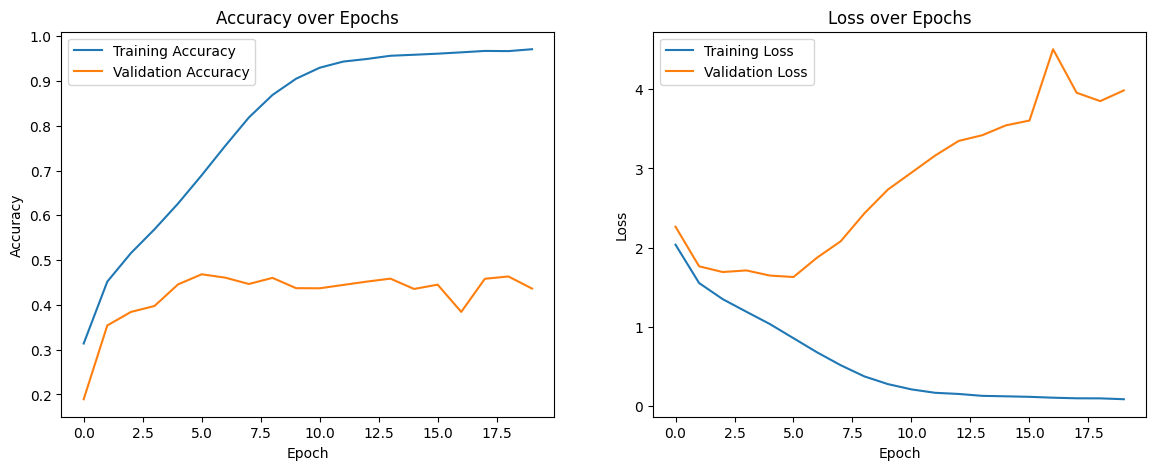

In [9]:
def plot_training_history(history):
    # График точности
    plt.figure(figsize=(14, 5))

    # Подграфик для точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Подграфик для потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_training_history(history)